# Workflow

1. Import and Preprocessing
2. Dataset exploration
3. Co-occurrence matrix construction
4. Graph
5. Plots
6. Report

<a id="loadlibraries"></a>
# `Load Libraries`
---

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
print("Loading dataset...")
df = pd.read_csv("02_terms.csv")
df.head()

,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
print("\n--- Dataset Overview ---")
print("Shape:", df.shape)
print("Column types:\n", df.dtypes)
print("\nFirst 5 rows:")
print(df.head())


Shape: (153, 22)

Column types:
 DocNumber      int64
advice         int64
author         int64
cold           int64
computing      int64
encourage      int64
examples       int64
information    int64
help           int64
lesson         int64
news           int64
opinion        int64
positions      int64
proposal       int64
recommend      int64
research       int64
sentiment      int64
slides         int64
suggestion     int64
tip            int64
tutorial       int64
users          int64
dtype: object


,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,...,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,77.000000,0.150327,0.052288,0.058824,0.065359,0.339869,0.111111,0.065359,0.300654,0.111111,...,0.071895,0.071895,0.450980,0.078431,0.052288,0.104575,0.078431,0.052288,0.104575,0.111111
std,44.311398,0.358565,0.223337,0.236067,0.247971,0.475220,0.315302,0.247971,0.460048,0.315302,...,0.259163,0.259163,0.499225,0.269732,0.223337,0.307010,0.269732,0.223337,0.307010,0.315302
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,115.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,153.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.columns

Index(['DocNumber', 'advice', 'author', 'cold', 'computing', 'encourage',
       'examples', 'information', 'help', 'lesson', 'news', 'opinion',
       'positions', 'proposal', 'recommend', 'research', 'sentiment', 'slides',
       'suggestion', 'tip', 'tutorial', 'users'],
      dtype='object')

In [30]:
# Trasformazione in formato long per analisi e grafi
df_long = df.melt(id_vars=['DocNumber'], 
                  var_name='term', 
                  value_name='frequency')

# Rinomina colonne per chiarezza
df_long.columns = ['document_id', 'term', 'frequency']

# Rimuove righe con frequenza zero (termine non presente)
df_long = df_long[df_long['frequency'] > 0]

# Reset index per sicurezza
df_long.reset_index(drop=True, inplace=True)

# Mostra una preview
df_long.head()

,document_id,term,frequency
0,16,advice,1
1,18,advice,1
2,19,advice,1
3,20,advice,1
4,21,advice,1


In [ ]:
print("➡️ Numero totale di righe:", df_long.shape[0])
print("➡️ Numero di documenti:", df_long['document_id'].nunique())
print("➡️ Numero di termini unici:", df_long['term'].nunique())



➡️ Numero totale di righe: 400
➡️ Numero di documenti: 139
➡️ Numero di termini unici: 21
➡️ Valori nulli:
 document_id    0
term           0
frequency      0
dtype: int64


In [37]:
print("Valori nulli:", df_long.isnull().sum())

Valori nulli: document_id    0
term           0
frequency      0
dtype: int64


In [19]:
# Frequenza aggregata per ciascun termine
term_freq = df_long.groupby('term')['frequency'].sum().sort_values(ascending=False)

# Visualizza le top 10
term_freq.head(10)


term
recommend    69
encourage    52
help         46
advice       23
news         20
lesson       17
users        17
examples     17
slides       16
tutorial     16
Name: frequency, dtype: int64

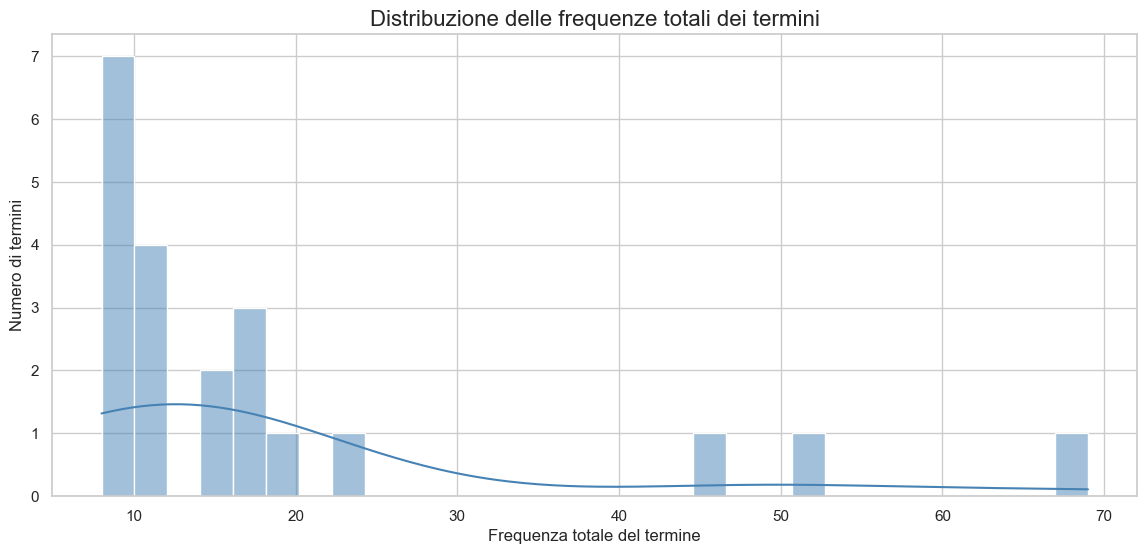

In [20]:
plt.figure(figsize=(14, 6))
sns.histplot(term_freq, bins=30, kde=True, color='steelblue')
plt.title('Distribuzione delle frequenze totali dei termini', fontsize=16)
plt.xlabel('Frequenza totale del termine')
plt.ylabel('Numero di termini')
plt.grid(True)
plt.show()


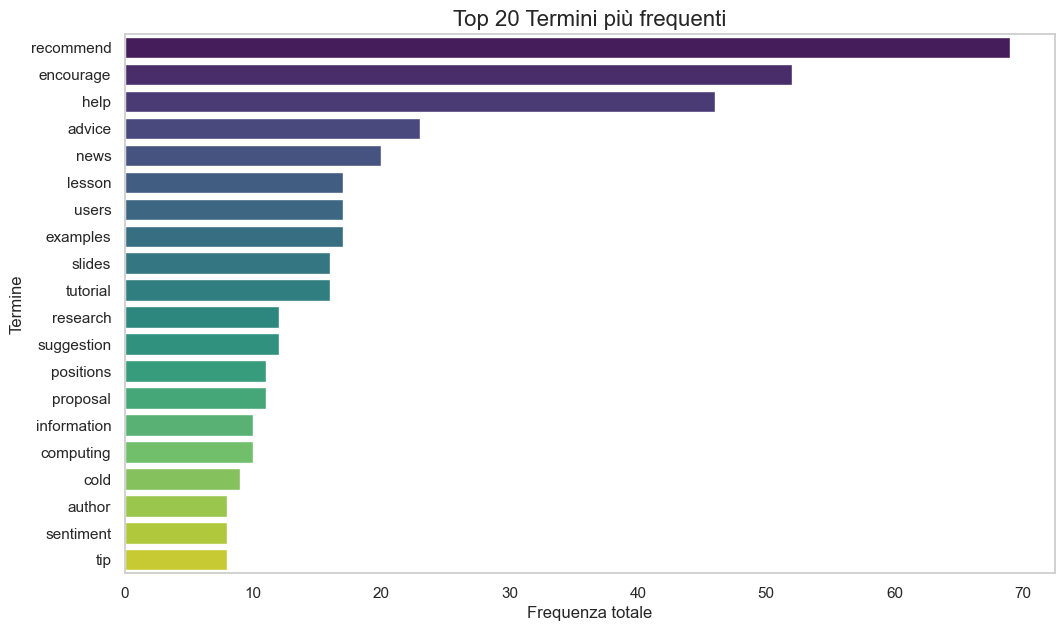

In [21]:
top_terms = term_freq.head(20)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 20 Termini più frequenti', fontsize=16)
plt.xlabel('Frequenza totale')
plt.ylabel('Termine')
plt.grid(axis='x')
plt.show()


In [38]:
# Raggruppa per documento → lista di termini presenti
doc_term_map = df_long.groupby('document_id')['term'].apply(list)

# Calcolo delle coppie di termini co-occorrenti
co_occurrence = Counter()
for terms in doc_term_map:
    pairs = combinations(set(terms), 2)  # set() per evitare duplicati nello stesso documento
    co_occurrence.update(pairs)

# Conversione in DataFrame
co_df = pd.DataFrame(co_occurrence.items(), columns=['pair', 'count'])
co_df[['term1', 'term2']] = pd.DataFrame(co_df['pair'].tolist(), index=co_df.index)
co_df.drop(columns=['pair'], inplace=True)
co_df = co_df[['term1', 'term2', 'count']]

# Visualizza le co-occorrenze più forti
co_df.sort_values(by='count', ascending=False).head(10)


,term1,term2,count
33,help,encourage,33
22,recommend,encourage,21
32,help,recommend,18
14,news,recommend,14
75,examples,recommend,14
19,users,recommend,9
38,advice,suggestion,9
4,computing,recommend,9
27,recommend,slides,8
50,recommend,advice,7


In [39]:
# Crea un grafo non orientato
G = nx.Graph()

# Aggiungi nodi (termini unici)
terms = pd.unique(co_df[['term1', 'term2']].values.ravel('K'))
G.add_nodes_from(terms)

# Aggiungi archi (co-occorrenze)
for _, row in co_df.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['count'])

print(f"✅ Nodi nel grafo: {G.number_of_nodes()}")
print(f"✅ Archi nel grafo: {G.number_of_edges()}")


✅ Nodi nel grafo: 21
✅ Archi nel grafo: 128


In [40]:
# Calcolo della centralità di grado
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Top 10 termini più centrali
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("🔝 Top 10 termini per centralità di grado:")
for term, score in top_degree:
    print(f"{term:<15} | {score:.3f}")


🔝 Top 10 termini per centralità di grado:
help            | 1.000
encourage       | 0.900
recommend       | 0.850
advice          | 0.850
tutorial        | 0.800
slides          | 0.750
users           | 0.700
lesson          | 0.700
examples        | 0.700
news            | 0.600


In [41]:
# Calcolo betweenness
betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

# Top 10 termini
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n🔝 Top 10 termini per betweenness centrality:")
for term, score in top_betweenness:
    print(f"{term:<15} | {score:.3f}")



🔝 Top 10 termini per betweenness centrality:
help            | 0.096
encourage       | 0.082
recommend       | 0.049
advice          | 0.044
lesson          | 0.029
tutorial        | 0.025
slides          | 0.019
suggestion      | 0.014
users           | 0.013
research        | 0.013


In [42]:
# Comunità tramite greedy modularity (simile a Louvain)
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Assegna community ai nodi
nx.set_node_attributes(G, community_map, 'community')
print(f"🎯 Numero di comunità trovate: {len(communities)}")


🎯 Numero di comunità trovate: 3


In [43]:
# Layout dei nodi
layout = nx.spring_layout(G, seed=42, k=0.5)

# Colori per comunità
colors = [community_map[node] for node in G.nodes()]
sizes = [5000 * degree_centrality[node] for node in G.nodes()]


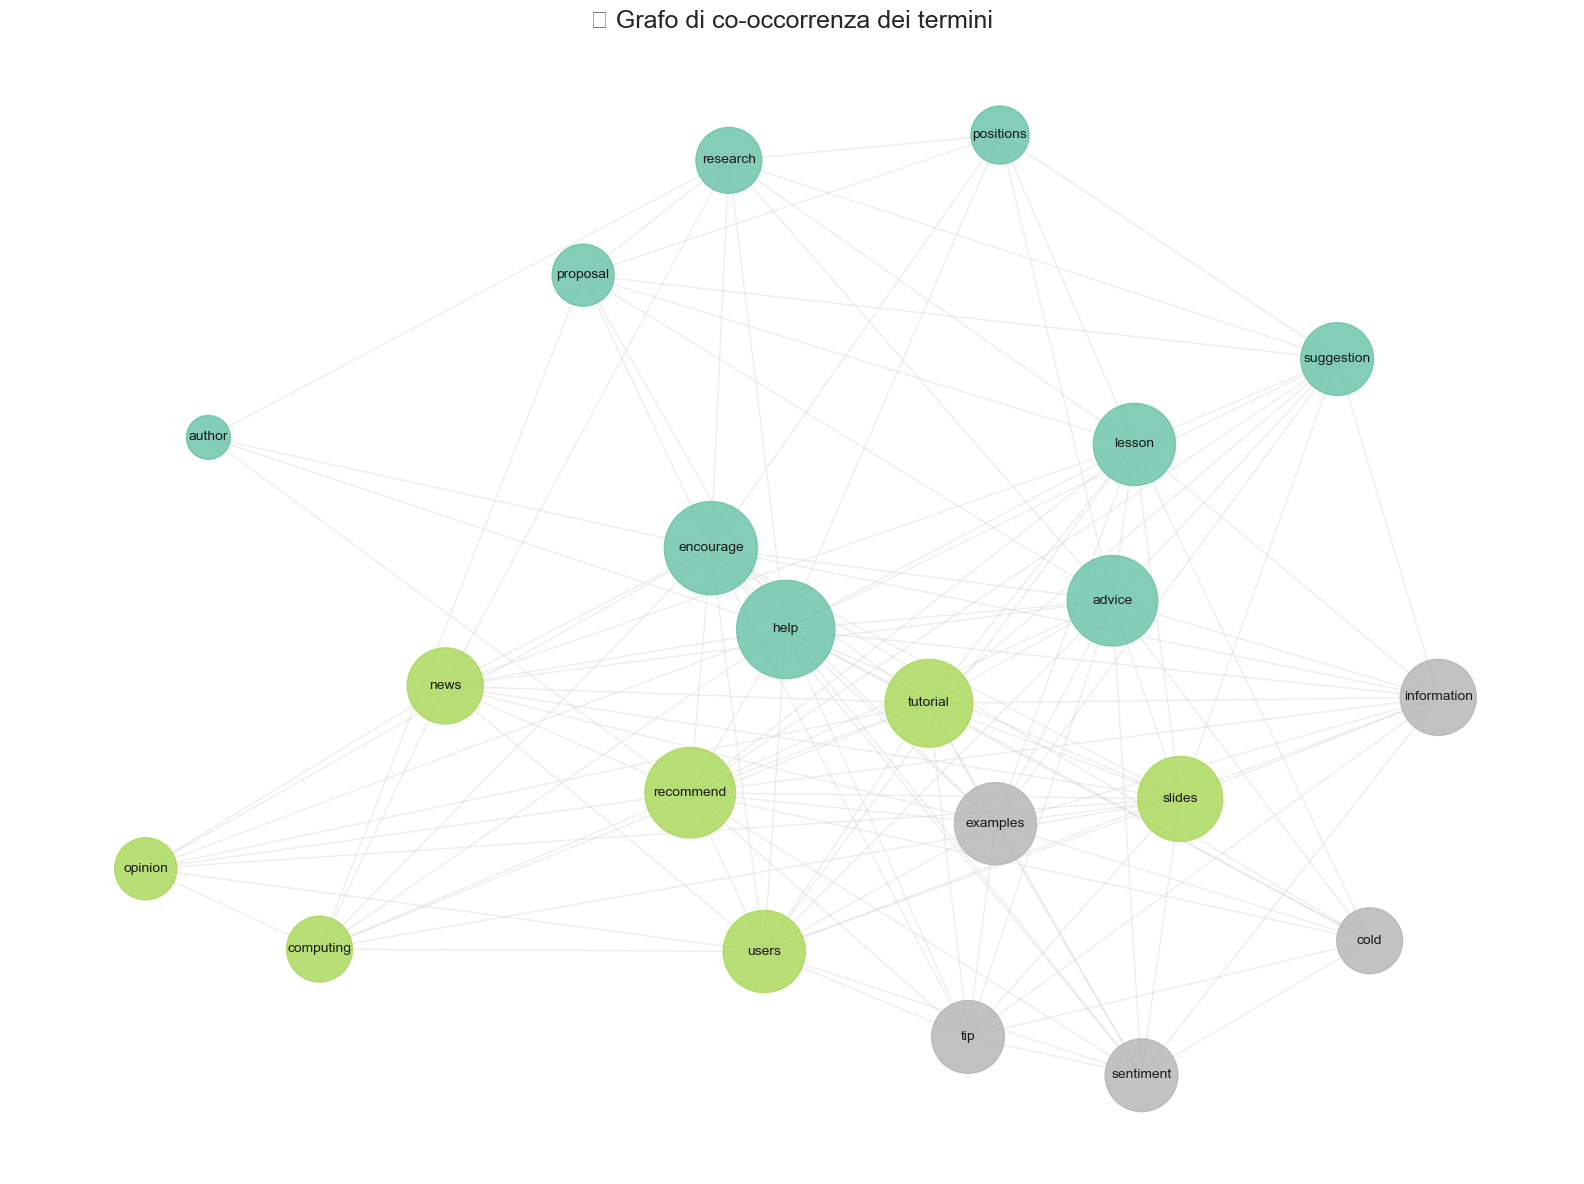

In [44]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, layout,
                       node_color=colors,
                       node_size=sizes,
                       cmap=plt.cm.Set2,
                       alpha=0.8)

nx.draw_networkx_edges(G, layout, 
                       edge_color='lightgray', 
                       alpha=0.4)

nx.draw_networkx_labels(G, layout,
                        font_size=10,
                        font_family='sans-serif')

plt.title("🔗 Grafo di co-occorrenza dei termini", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()
